# EEC55C30 Lab2
## (b) Superdense coding

### Enviroment setup

In [18]:
# qiskit tools
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit_ibm_runtime import Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_bloch_vector
# general tools
import numpy as np
from qiskit_ibm_runtime import QiskitRuntimeService

### Paras

In [30]:
nshots = 1000
np.random.seed(1)  


## B.1 Protocol
### Assumption: Alice has two bits of information, say, a1, a2 ∈ {00, 01, 10, 11}.
### Alice and Bob share an entangled pair (e-bit), but they cannot communicate classically.

Alice performs one of the following operations on her part of the e-bit:

- If \(a_1a_2 = 00\), she does nothing.  
- If \(a_1a_2 = 01\), she applies the **Z** gate.  
- If \(a_1a_2 = 10\), she applies the **X** gate.  
- If \(a_1a_2 = 11\), she applies **Z** followed by **X**.

Alice then sends her part of the e-bit to Bob's location.

Bob applies:

1. A CNOT gate (Alice's qubit = control, Bob's qubit = target)  
2. An H gate to Alice's qubit  
3. Measures the two qubits.

The possible starting states and the results of Bob's operations are:




$$
\frac{|00\rangle + |11\rangle}{\sqrt{2}}
\;\xrightarrow{\,CX_{01}\otimes H_0\,}\;
|00\rangle
$$


$$
\frac{|00\rangle - |11\rangle}{\sqrt{2}}
\;\xrightarrow{\,CX_{01}\otimes H_0\,}\;
|01\rangle
$$

$$
\frac{|10\rangle + |01\rangle}{\sqrt{2}}
\;\xrightarrow{\,CX_{01}\otimes H_0\,}\;
|10\rangle
$$


$$
\frac{|10\rangle - |01\rangle}{\sqrt{2}}
\;\xrightarrow{\,CX_{01}\otimes H_0\,}\;
-|11\rangle
$$




## B2. Quantum circuit simulating the superdense coding

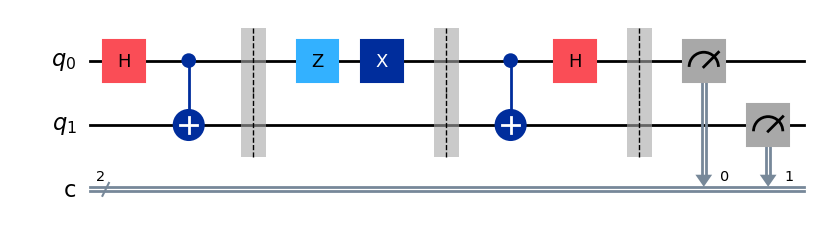

In [ ]:
qc = QuantumCircuit(2, 2)
 
# Eve creates EPR pair and send q0 to Alice and q1 to Bob
# step 1: Alic holds qubit A, Bob holds qubit B, Bell state |Φ+> = (|00> + |11>)/√2
qc.h(0)
qc.cx(0, 1)
qc.barrier()
 

# set message which Alice wants to transform to Bob
msg = "11"         

# step 2: Alice performs unitary operations on her qubit according to the message
# This is the way to convert a qubit to the entangled states
# Alice sends 2 classical bits, but only 1 qubit to Bob
if msg == "00":
    pass
elif msg == "10":
    qc.x(0)
elif msg == "01":
    qc.z(0)
elif msg == "11":
    qc.z(0)
    qc.x(0)
 
qc.barrier()
# Bob receives EPR qubit from Alice and performs unitary operations
qc.cx(0, 1)
qc.h(0)
qc.barrier()
 
# Bob measures q0 and q1
qc.measure(0, 0)
qc.measure(1, 1)
 
qc.draw(output="mpl")

note: Einstein–Podolsky–Rosen pair（EPR pair）, max entangled qubits

In [21]:
# Define backend
backend = AerSimulator()
 
# Transpile to backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(qc)
 
# Run the job
sampler = Sampler(mode=backend)
job_sim = sampler.run([isa_qc], shots=nshots)
result_sim = job_sim.result()
 
# Extract counts data
counts = result_sim[0].data.c.get_counts()
print(counts)

{'11': 1000}


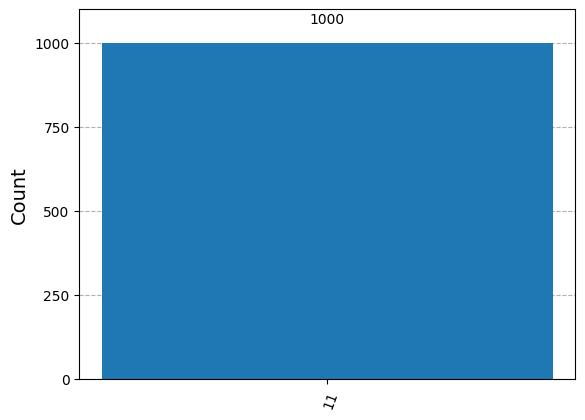

In [22]:
plot_histogram(counts)

In [24]:
service = QiskitRuntimeService()
backend = service.least_busy(operational=True)
print("The least busy device is ", backend)

qiskit_runtime_service.__init__:WARNING:2025-11-13 17:45:31,070: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-13 17:45:31,442: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-11-13 17:45:32,851: Using instance: open-instance, plan: open


The least busy device is  <IBMBackend('ibm_torino')>


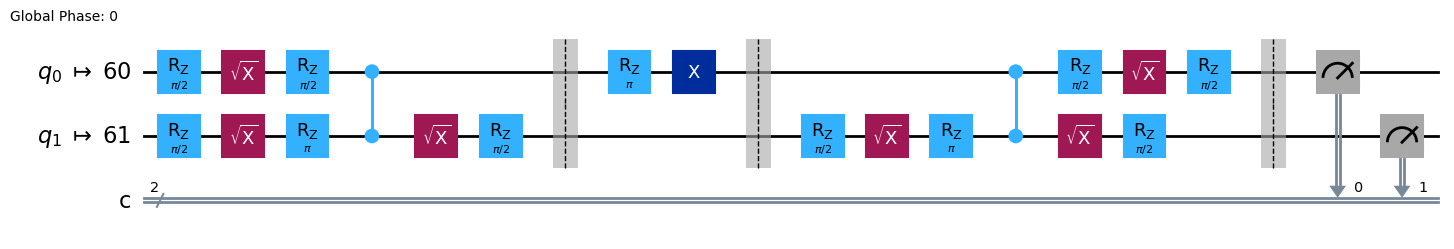

In [25]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
qc_compiled = pm.run(qc)
 
qc_compiled.draw("mpl", idle_wires=False)

In [26]:
sampler = Sampler(backend)
job = sampler.run([qc_compiled])
job_id = job.job_id()
print("job id:", job_id)

job id: d4b1i9ki51bc738ijuhg


In [27]:
job = service.job(job_id)  # Input your job-id between the quotations
job.status()

'DONE'

In [28]:
real_result = job.result()
print(real_result[0].data.c.get_counts())

{'11': 3932, '01': 90, '00': 20, '10': 54}


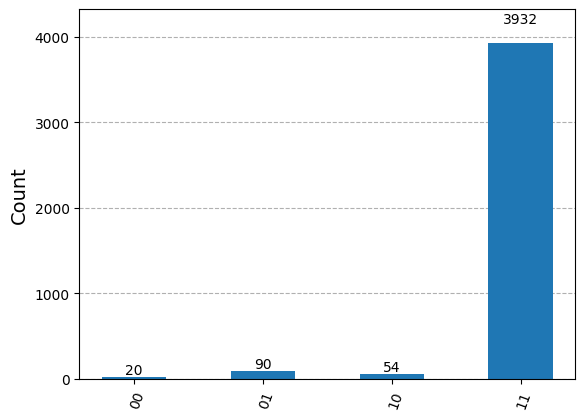

In [29]:
plot_histogram(real_result[0].data.c.get_counts())

note:
- Quantum teleportation: Although we cannot copy quantum states, we can teleport unknown quantum states by having shared entanglement.
- Quantum superdense coding: A shared entangled pair, and transfer of one qubit, enable the communication of two bits of classical information.
- One Qubit sent corresponding to 2 classical bits.